In [243]:
import os
import numpy as np
import quaternion
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
from open3d import JVisualizer

In [244]:
data_dir = '/mnt/storage2/data/tmp'

In [245]:
os.listdir(data_dir)

['oLBMNvg9in8', 'oLBMNvg9in8.zip']

In [246]:
scene = 'oLBMNvg9in8'
scene_dir = os.path.join(data_dir, scene, '0')

In [304]:
agent_path = []
lcam_path = []
rcam_path = []

left_cam = np.array([-0.1,1,0,1])
right_cam = np.array([0.1,1,0,1])

pose_files = sorted(os.listdir(os.path.join(scene_dir, 'pose')), key=lambda x: int(os.path.splitext(x)[0]))
path_len = 47 #len(pose_files)

for filename in pose_files[0:path_len]:
    pose = np.load(os.path.join(scene_dir, 'pose', filename), allow_pickle=True).item()
    position = pose['position']
    agent_path.append(position)
    
    rot = Rotation.from_quat([pose['rotation'].x, pose['rotation'].y, pose['rotation'].z, pose['rotation'].w])
    R = np.eye(4)
    R[:3, :3] = rot.as_matrix()
    print(np.rad2deg(rot.as_rotvec()))

    T = np.eye(4)
    T[:3, 3] = position
#     T[2,2] = -1
    
    M = (T @ R)[:3, :]
    lcam_path.append(M @ left_cam)
    rcam_path.append(M @ right_cam)
    
agent_path = np.array(agent_path)
lcam_path = np.array(lcam_path)
rcam_path = np.array(rcam_path)
agent_path.shape

[0.         9.98240913 0.        ]
[ 0.         19.96200092  0.        ]
[ 0.         29.94159272  0.        ]
[ 0.         39.92118452  0.        ]
[ 0.         49.90077632  0.        ]
[ 0.         59.88036812  0.        ]
[ 0.         69.85995992  0.        ]
[ 0.         79.83955172  0.        ]
[ 0.         89.81914352  0.        ]
[ 0.         99.79873532  0.        ]
[  0.         109.77832712   0.        ]
[  0.         119.75791892   0.        ]
[  0.         129.73751072   0.        ]
[  0.         139.71710252   0.        ]
[  0.         149.69669432   0.        ]
[  0.         159.67628612   0.        ]
[  0.         169.65587792   0.        ]
[  0.         179.63546972   0.        ]
[  0.         179.63546971   0.        ]
[  0.         169.64897083   0.        ]
[  0.         159.66247195   0.        ]
[  0.         149.67597307   0.        ]
[  0.         139.68947419   0.        ]
[  0.         129.70297532   0.        ]
[  0.         119.71647644   0.        ]
[  0.   

[  0.         158.67356278   0.        ]
[  0.         149.29723571   0.        ]
[  0.         139.92090863   0.        ]
[  0.         130.54458156   0.        ]
[  0.         121.16825448   0.        ]
[  0.        111.7919274   0.       ]
[  0.         102.41560033   0.        ]
[ 0.         93.03927325  0.        ]
[ 0.         93.03927351  0.        ]
[ 0.         93.03927351  0.        ]
[ 0.         93.03927351  0.        ]
[  0.        101.6672347   0.       ]
[  0.         110.29519589   0.        ]
[  0.         118.92315708   0.        ]
[  0.         127.55111827   0.        ]
[  0.         136.17907945   0.        ]
[  0.         144.80704064   0.        ]
[  0.         153.43500183   0.        ]
[  0.         153.43500183   0.        ]
[  0.         162.29000122   0.        ]
[  0.         171.14500061   0.        ]
[  0. 180.   0.]
[  0. 180.   0.]
[  0.         170.20354744   0.        ]
[  0.         160.40709488   0.        ]
[  0.         150.61064232   0.        ]


[  0. 180.   0.]
[  0. 180.   0.]
[  0. 180.   0.]


(577, 3)

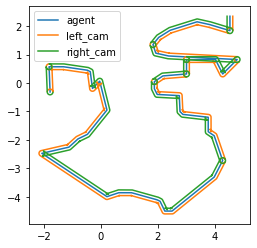

In [305]:
plt.plot(agent_path[:, 0], agent_path[:, 2], label='agent')
plt.plot(lcam_path[:, 0], lcam_path[:, 2], label='left_cam')
plt.plot(rcam_path[:, 0], rcam_path[:, 2], label='right_cam')
plt.gca().set_aspect('equal')
plt.legend()

In [306]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect( u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)

    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

In [307]:
def get_pcd(scene_dir, fileidx, side='l', fliplr=False):
    if side=='l':
        side = 'left'
    else:
        side = 'right'
        
    depth = cv2.imread(os.path.join(scene_dir, f'{side}_depth', f'{fileidx}.png'), -1).astype(np.float32)/6553.5
    
    if fliplr:
        depth = np.fliplr(depth)

    camera_intrinsics = camera_intrinsic_transform(320, 320, 320, 240)
    pc = img_to_lid(depth, camera_intrinsics)
    
    M = np.array([[1,0,0], [0,-1,0], [0,0,-1]]) # To flip y-axis up and z-axis to follow right hande rule.
        
    pc = (M @ pc.T).T

    rgb = cv2.imread(os.path.join(scene_dir,  f'{side}_rgb', f'{fileidx}.jpg'), -1)
    if fliplr:
        rgb = np.fliplr(rgb)
        
    colors = rgb.reshape((-1,3)).astype(np.float32)/255

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd

In [308]:
def get_transform(scene_dir, fileidx):
    pose = np.load(os.path.join(scene_dir, 'pose', f'{fileidx}.npy'), allow_pickle=True).item()
    position = pose['position']
    
    rot = Rotation.from_quat([pose['rotation'].x, pose['rotation'].y, pose['rotation'].z, pose['rotation'].w])
    R = np.eye(4)
    R[:3, :3] = rot.as_matrix()

    T = np.eye(4)
    T[:3, 3] = position
    
    M = (T @ R)
    
    return M

# Spatial Stereo registration test

In [14]:
fliplr = True
fileidx = os.path.splitext(pose_files[100])[0]
lpcd = get_pcd(scene_dir, fileidx, fliplr=fliplr)
rpcd = get_pcd(scene_dir, fileidx, 'r', fliplr=fliplr)

M = np.array([[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
if fliplr:
    M[0,-1] *= -1
rpcd = rpcd.transform(M)

visualizer = JVisualizer()
visualizer.add_geometry(lpcd)
visualizer.add_geometry(rpcd)

visualizer.show()

JVisualizer with 2 geometries

In [15]:
visualizer.close_all()
del lpcd, rpcd

# Temporal Stereo registration test

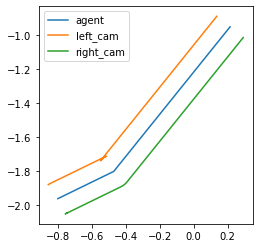

In [309]:
idx_1 = 100
idx_2 = 110
plt.plot(agent_path[idx_1:idx_2+1, 0], agent_path[idx_1:idx_2+1, 2], label='agent')
plt.plot(lcam_path[idx_1:idx_2+1, 0], lcam_path[idx_1:idx_2+1, 2], label='left_cam')
plt.plot(rcam_path[idx_1:idx_2+1, 0], rcam_path[idx_1:idx_2+1, 2], label='right_cam')
plt.gca().set_aspect('equal')
plt.legend()

In [310]:
fliplr = True
pcd1 = get_pcd(scene_dir, idx_1, fliplr=fliplr)
pcd2 = get_pcd(scene_dir, idx_2, fliplr=fliplr)

M_1 = get_transform(scene_dir, idx_1)
M_2 = get_transform(scene_dir, idx_2)

if fliplr:
    M_1[0,3] *= (1 - 2*fliplr)
    M_2[0,3] *= (1 - 2*fliplr)
    
M_1_2 = np.linalg.inv(M_1) @ M_2  # To convert from frame 2 to 1.
pcd2 = pcd2.transform(M_1_2)

visualizer = JVisualizer()
visualizer.add_geometry(pcd1)
visualizer.add_geometry(pcd2)

visualizer.show()

JVisualizer with 2 geometries

In [311]:
visualizer.close_all()
del pcd1, pcd2

# Test - Fliplr makes change for relative pose transform for temporal case

In [229]:
M1 = np.array([[1, 0, 0, 2], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
M2 = np.array([[1, 0, 0, -2], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

In [230]:
A1 = np.array([0.2, 0.4, 0, 1])  # A point in frame M2 
A1

array([0.2, 0.4, 0. , 1. ])

In [231]:
A2 = np.array([-3.8, 0.4, 0, 1]) # Same point in frame M1
A2

array([-3.8,  0.4,  0. ,  1. ])

In [232]:
C = np.linalg.inv(M1) @ (M2 @ A1)
C

array([-3.8,  0.4,  0. ,  1. ])

In [233]:
np.isclose(C, A2)

array([ True,  True,  True,  True])

In [234]:
fliplr = True

if fliplr:
    A1 = A1 * np.array([-1, 1, 1, 1])
    A2 = A2 * np.array([-1, 1, 1, 1])
    
A1, A2

(array([-0.2,  0.4,  0. ,  1. ]), array([3.8, 0.4, 0. , 1. ]))

In [235]:
D = np.linalg.inv(M1) @ (M2 @ A1)
D

array([-4.2,  0.4,  0. ,  1. ])

In [236]:
np.isclose(C, D)

array([False,  True,  True,  True])

In [237]:
# Using a matrix to flip the entire transformed point cloud fails.
# Its because the point-cloud is already flipped locally about its own center and this reverses that.

CM = np.array([[1 - 2*fliplr, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
E = np.linalg.inv(CM@ M1) @ (CM @ M2 @ A1)
E

array([-4.2,  0.4,  0. ,  1. ])

In [238]:
np.isclose(E, A2)

array([False,  True,  True,  True])

In [239]:
# We just need to flip the x-coordinate of the camera's world pose.
M1[0,3] *= (1 - 2*fliplr)
M2[0,3] *= (1 - 2*fliplr)

M1, M2

(array([[ 1,  0,  0, -2],
        [ 0,  1,  0,  0],
        [ 0,  0,  1,  0],
        [ 0,  0,  0,  1]]),
 array([[1, 0, 0, 2],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]))

In [240]:
F = np.linalg.inv(M1) @ (M2 @ A1)
F

array([3.8, 0.4, 0. , 1. ])

In [241]:
np.isclose(F, A2)

array([ True,  True,  True,  True])